In [2]:
import re
import nltk
import textstat
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import Counter
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import pymongo


nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to E:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
def connect_mongo(query={},host='localhost', port=27017, username=None, password=None, db='test'):
    if username and password:
        mongo_uri = "mongodb://%s:%s@%s:%s/%s" % (username, password, host, port, db)
        client = pymongo.MongoClient(mongo_uri)
    else:
        client = pymongo.MongoClient(host, port)
    return client
    
client = connect_mongo()
collect = client.issues.first_issues
tmp_collect = client.gfibot.resolved_issue
# db = collect.find({"resolver_commit_num":{"$gte": 0, "$lte": 2}}).sort("closed_at",pymongo.ASCENDING)

In [4]:
df = pd.DataFrame(list(collect.find()))

In [5]:
otc = set()
notc = set()
cnt = 0
for data in collect.find():
    if tmp_collect.count_documents({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}) <= 1:
#         print(data["owner"], data["name"], data["resolver"],tmp_collect.count_documents({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}))
        otc.add(data["owner"]+"/"+data["name"]+"/"+data["resolver"])
    else:
        res = tmp_collect.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}).sort([("resolved_at",-1)]).limit(1)
        for item in res:
            if (item["resolved_at"]-data["closed_at"]).days<7:
                otc.add(item["owner"]+"/"+item["name"]+"/"+item["resolver"])
            else:
                notc.add(item["owner"]+"/"+item["name"]+"/"+item["resolver"])

In [6]:
len(otc),len(notc)

(8779, 3078)

In [7]:
otc_iss, notc_iss = df[(df.owner+"/"+df.name+"/"+df.resolver).isin(otc)], df[~(df.owner+"/"+df.name+"/"+df.resolver).isin(otc)]

In [8]:
len(otc_iss), len(notc_iss)

(11308, 3633)

In [8]:
metrics = [
    "len_title", "len_body", 
    "n_code_snips", "n_urls", "n_imgs", 
    "changed_files","additions","deletions",
    "coleman_liau_index", 
    "flesch_reading_ease", "flesch_kincaid_grade", "automated_readability_index",     
]

In [9]:
otc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,changed_files,additions,deletions,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,11308.000000,11308.000000,11308.000000,11308.000000,11308.000000,11308.000000,1.130800e+04,11308.000000,11308.000000,11308.000000,11308.000000,11308.000000
mean,7.725946,103.780952,0.759462,1.503803,0.010789,4.472232,4.162803e+02,155.014326,16.494021,50.040508,9.677724,17.484781
std,3.281327,102.195567,1.302953,3.338682,0.134545,18.578483,2.136976e+04,3991.849728,30.369371,78.802023,11.090230,28.504328
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-28.010000,-4550.100000,-15.700000,-6.900000
25%,5.000000,37.000000,0.000000,0.000000,0.000000,1.000000,3.000000e+00,1.000000,9.730000,44.410000,6.800000,10.300000
50%,7.000000,75.000000,0.000000,1.000000,0.000000,2.000000,1.300000e+01,2.000000,12.460000,57.870000,8.700000,13.400000
75%,10.000000,142.000000,1.000000,2.000000,0.000000,4.000000,5.300000e+01,11.000000,16.600000,68.160000,11.100000,17.800000
max,40.000000,2504.000000,18.000000,274.000000,6.000000,1054.000000,2.048587e+06,209823.000000,1925.410000,206.840000,650.600000,1609.300000


In [10]:
notc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,changed_files,additions,deletions,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000,3633.000000
mean,7.631159,97.160749,0.707680,1.263969,0.010460,5.209194,266.168181,201.535370,14.965973,54.881164,9.033113,16.193421
std,3.215967,125.911457,1.315106,1.994752,0.132332,18.371630,3773.408289,3754.905678,16.087902,44.778129,6.768879,16.021286
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.810000,-978.590000,-15.700000,-4.400000
25%,5.000000,34.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,9.500000,44.910000,6.600000,10.100000
50%,7.000000,70.000000,0.000000,1.000000,0.000000,2.000000,17.000000,3.000000,12.470000,58.790000,8.500000,13.400000
75%,9.000000,135.000000,1.000000,2.000000,0.000000,4.000000,64.000000,13.000000,16.620000,69.280000,11.100000,17.800000
max,34.000000,5610.000000,36.000000,61.000000,3.000000,278.000000,150981.000000,119792.000000,291.300000,206.840000,150.000000,295.100000


In [11]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")

len_title                      MannwhitneyuResult(statistic=20263213.0, pvalue=0.10850840442417392)
len_body                       MannwhitneyuResult(statistic=19721777.5, pvalue=0.00014611457243635752)
n_code_snips                   MannwhitneyuResult(statistic=20227886.0, pvalue=0.055270310575682866)
n_urls                         MannwhitneyuResult(statistic=19221950.0, pvalue=5.676056537889826e-10)
n_imgs                         MannwhitneyuResult(statistic=20525006.0, pvalue=0.32653138896678247)
changed_files                  MannwhitneyuResult(statistic=19461810.0, pvalue=3.257890447287609e-07)
additions                      MannwhitneyuResult(statistic=19292288.5, pvalue=1.6057187732079697e-08)
deletions                      MannwhitneyuResult(statistic=20054111.5, pvalue=0.014950942621549456)
coleman_liau_index             MannwhitneyuResult(statistic=20177606.5, pvalue=0.05406751885470192)
flesch_reading_ease            MannwhitneyuResult(statistic=19928225.5, pvalue=0.0033717

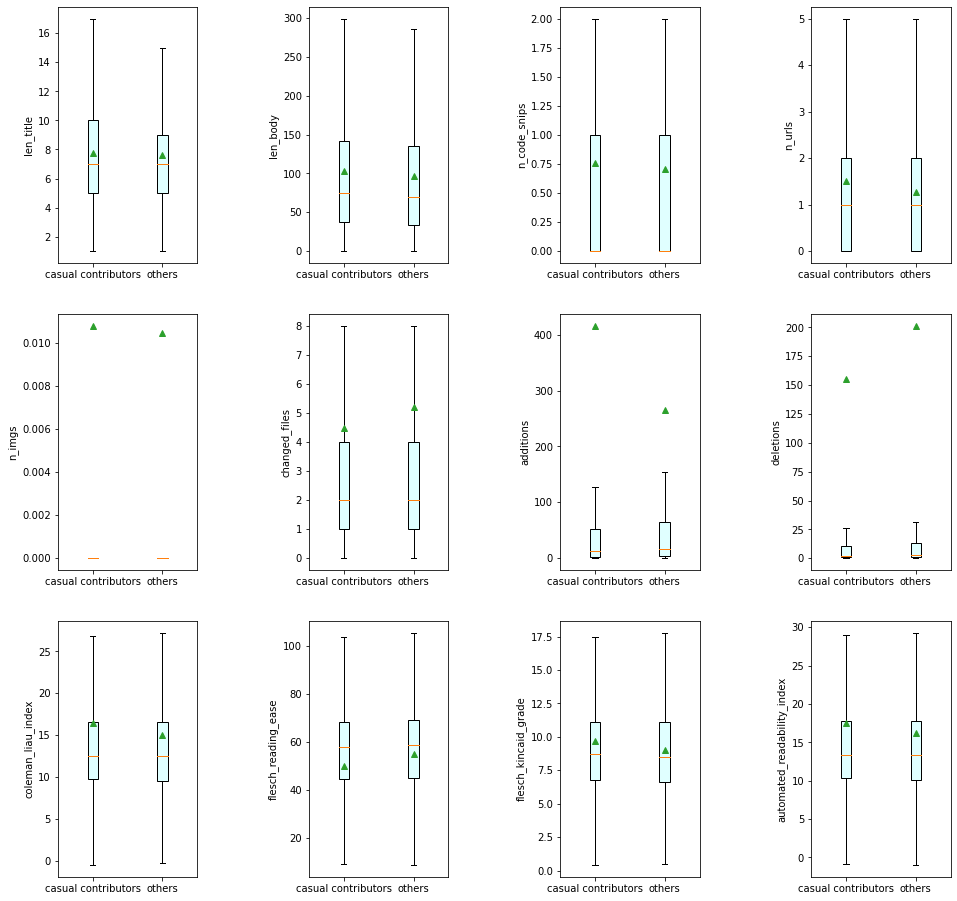

In [131]:
fig, ax_array = plt.subplots(nrows=3, ncols=4, figsize=(16, 16), sharey=False)

i = 0
labels = ['casual contributors', 'others']
for ax_lst in ax_array:
    for ax in ax_lst:
        a = ax.boxplot([otc_iss[metrics[i]],notc_iss[metrics[i]]],
                       patch_artist=True,
                       boxprops={'facecolor':'#e0ffff'},
                       showmeans=True,
                       showfliers = False,
                       labels=labels)
        ax.set_ylabel(metrics[i])
        i+=1

# plt.xticks(np.arange(0, len(labels)), labels)
plt.subplots_adjust(wspace=0.8)
plt.show()

In [12]:
list(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.17721966749204104),
 ('help wanted', 0.11381322957198443),
 ('bug', 0.10806508666430846),
 ('Bug', 0.08180049522461974),
 ('enhancement', 0.05359037849310223),
 ('Docs', 0.023523169437566323),
 ('waffle:review', 0.023434736469755926),
 ('accepted', 0.022904138662893526),
 ('Effort Low', 0.02175451008135833),
 ('easy', 0.019985850725150335),
 ('Easy', 0.01954368588609834),
 ('Documentation', 0.019278386982667137),
 ('feature-request', 0.017509727626459144),
 ('docs', 0.017067562787407144),
 ('rule', 0.016979129819596747),
 ('<Bug>', 0.01627166607711355),
 ('up-for-grabs', 0.01556420233463035),
 ('hacktoberfest', 0.015033604527767952),
 ('type: bug', 0.014679872656526352),
 ('Good First Issue', 0.013707110010611956)]

In [13]:
list(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.1951555188549408),
 ('bug', 0.14726121662537847),
 ('help wanted', 0.1043214973850812),
 ('Bug', 0.08422791081750619),
 ('enhancement', 0.05835397742912194),
 ('feature-request', 0.03192953481970823),
 ('Good First Issue', 0.02339664189375172),
 ('Effort Low', 0.022295623451692816),
 ('accepted', 0.018717313515001378),
 ('Docs', 0.018166804293971925),
 ('Easy', 0.018166804293971925),
 ('in progress', 0.017341040462427744),
 ('easy', 0.01706578585191302),
 ('<Bug>', 0.016790531241398295),
 ('effort/small', 0.015414258188824663),
 ('rule', 0.015414258188824663),
 ('type: bug', 0.014588494357280485),
 ('Documentation', 0.014588494357280485),
 ('Hacktoberfest', 0.014313239746765759),
 ('beta', 0.012936966694192129)]

In [11]:
counter1 = Counter()
for cat in otc_iss.label_category:
    counter1.update(cat)
total = len(otc_iss)
# total = sum(counter1.values())
for k, v in counter1.items():
    counter1[k] = v / total
counter1

Counter({'bug': 0.2801556420233463,
         'feature': 0.0614609126282278,
         'test': 0.026441457375309514,
         'build': 0.013441811107180757,
         'doc': 0.09550760523523169,
         'coding': 0.01830562433675274,
         'enhance': 0.08631057658295012,
         'gfi': 0.38574460558896356,
         'medium': 0.023523169437566323,
         'major': 0.055093738945879024,
         'triaged': 0.08100459851432613,
         'untriaged': 0.016094800141492747})

In [13]:
counter2 = Counter()
for cat in notc_iss.label_category:
    counter2.update(cat)
total = len(notc_iss)
# total = sum(counter2.values())
for k, v in counter2.items():
    counter2[k] = v / total
counter2

Counter({'bug': 0.3212221304706854,
         'feature': 0.07569501789154968,
         'test': 0.02614918799889898,
         'build': 0.020919350399119185,
         'doc': 0.06908890723919625,
         'coding': 0.026424442609413706,
         'enhance': 0.09716487751169832,
         'gfi': 0.4026974951830443,
         'medium': 0.020368841178089733,
         'major': 0.04459124690338563,
         'triaged': 0.08257638315441784,
         'untriaged': 0.018717313515001378})

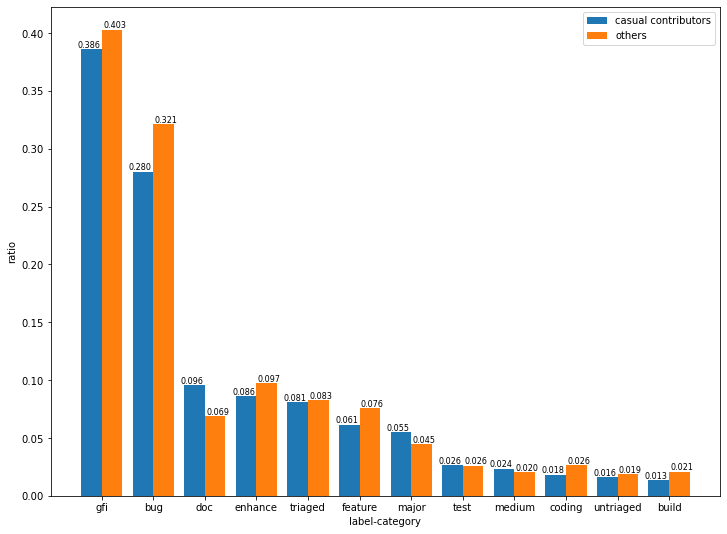

In [14]:
# from matplotlib import rcParams
# rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(12,9))
# x_counter = np.arange(len(counter1.keys()))
# y_counter1 = counter1.values()
# y_counter2 = counter2.values()

# 按照otc的value降序排列
tmp_lst = sorted(counter1.items(), key=lambda x:-x[1])
# x轴
x_counter = np.arange(len(tmp_lst))
x_label = [i[0] for i in tmp_lst]
# y轴
y_counter1 = [i[1] for i in tmp_lst]
y_counter2 = [counter2[key] for key in x_label]


# plt.plot(x_counter, y_counter1, marker='o',label='')
plt.bar(x_counter-0.2, y_counter1, width=0.4, align='center', label='casual contributors')
# plt.plot(x_counter, y_counter2, marker='*',label='非偶然贡献者')
plt.bar(x_counter+0.2, y_counter2, width=0.4, align='center', label='others')
plt.legend()  # 让图例生效

for a, b in zip(x_counter, y_counter1):
    plt.text(a-0.25, b, '%.3f' % b, ha='center', va='bottom', fontsize=8)
for a, b in zip(x_counter, y_counter2):
    plt.text(a+0.25, b, '%.3f' % b, ha='center', va='bottom', fontsize=8)

# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="upper right")
plt.xlabel('label-category')
plt.xticks(x_counter, x_label)
plt.ylabel('ratio')
plt.savefig(r'D:\label-category.png')

In [42]:
otc_events = dict(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

In [43]:
notc_events = dict(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

True


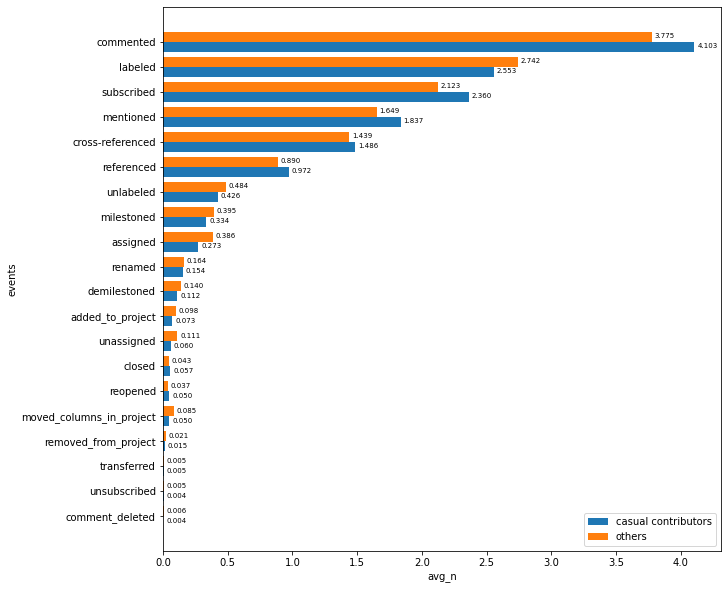

In [87]:
plt.figure(figsize=(10,10))
# x轴，两个x轴的并集
x_counter = otc_events.keys()
x_counter1 = notc_events.keys()
print(x_counter == x_counter1)
x_counter = list(set(x_counter) | set(x_counter1))
# 按照otc的value降序排列
y_counter1 = [(otc_events[key] if key in otc_events.keys() else 0) for key in x_counter]
tmp_lst = sorted(dict(zip(x_counter, y_counter1)).items(), key=lambda x:x[1])
# x轴
x_counter = np.arange(len(tmp_lst))
x_label = [i[0] for i in tmp_lst]
# y轴
# y_counter1 = otc_events.values()
# y_counter2 = [notc_events[key] for key in x_counter]
y_counter1 = [i[1] for i in tmp_lst]
y_counter2 = [(notc_events[key] if key in notc_events.keys() else 0) for key in x_label]

for a, b in zip(y_counter1, x_counter):
    plt.text(a+0.1, b-0.3, '%.3f' % a, ha='center', va='bottom', fontsize=7)
for a, b in zip(y_counter2, x_counter):
    plt.text(a+0.1, b+0.1, '%.3f' % a, ha='center', va='bottom', fontsize=7)

plt.barh(x_counter-0.2, y_counter1, height=0.4, align='center', label='casual contributors')
plt.barh(x_counter+0.2, y_counter2, height=0.4, align='center', label='others')

plt.legend()  # 让图例生效
 
plt.legend(loc="lower right")
plt.xlabel('avg_n')
plt.ylabel('events')
plt.yticks(x_counter, x_label)
# res = plt.xticks(rotation=90)
# plt.savefig(r'D:\events.png')
# 自动保存图片有问题，需要手动下载

In [173]:
otc_pr = otc_iss[otc_iss["resolved_in"].apply(lambda x:isinstance(x, int))]
notc_pr = notc_iss[notc_iss["resolved_in"].apply(lambda x:isinstance(x, int))]

print(otc_iss['commit_num'].describe())
print(notc_iss['commit_num'].describe())
print(mannwhitneyu(otc_pr.commit_num, notc_pr.commit_num))

# fig, ax = plt.subplots(figsize=(7, 7), sharey=False)
# i = 0
# labels = ['casual contributors', 'others']
# a = ax.boxplot([otc_pr['commit_num'],notc_pr['commit_num']],
#                patch_artist=True,
#                boxprops={'facecolor':'#e0ffff'},
#                showmeans=True,
#                showfliers = False,
#                labels=labels)
# ax.set_ylabel('commit_num')

# # plt.xticks(np.arange(0, len(labels)), labels)
# plt.subplots_adjust(wspace=0.8)
# plt.show()

count    10375.000000
mean         3.833639
std          7.285767
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        148.000000
Name: commit_num, dtype: float64
count    3327.000000
mean        4.939585
std        11.373171
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       153.000000
Name: commit_num, dtype: float64
MannwhitneyuResult(statistic=15791969.0, pvalue=3.2249307367234418e-15)


In [15]:
otc_data, notc_data = otc_iss.copy(), notc_iss.copy()

In [16]:
otc_data['n_comment'] = otc_data.comments.map(len)
notc_data['n_comment'] = notc_data.comments.map(len)
print(otc_data['n_comment'].describe(),notc_data['n_comment'].describe())
print(mannwhitneyu(otc_data['n_comment'], notc_data['n_comment']))

count    11308.000000
mean         4.118412
std          6.384114
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        178.000000
Name: n_comment, dtype: float64 count    3633.000000
mean        3.782274
std         5.785225
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       188.000000
Name: n_comment, dtype: float64
MannwhitneyuResult(statistic=19888149.5, pvalue=0.0017792558824696843)


In [17]:
otc_data['n_event'] = otc_data.events.map(len)
notc_data['n_event'] = notc_data.events.map(len)
print(otc_data['n_event'].describe(),notc_data['n_event'].describe())
print(mannwhitneyu(otc_data['n_event'], notc_data['n_event']))

count    11308.000000
mean        14.932437
std         18.596345
min          0.000000
25%          6.000000
50%         10.000000
75%         18.000000
max        485.000000
Name: n_event, dtype: float64 count    3633.000000
mean       14.606111
std        15.832648
min         0.000000
25%         6.000000
50%        10.000000
75%        18.000000
max       446.000000
Name: n_event, dtype: float64
MannwhitneyuResult(statistic=20209846.0, pvalue=0.07141181086840946)


In [18]:
otc_data['n_label'] = otc_data.labels.map(len)
notc_data['n_label'] = notc_data.labels.map(len)
print(otc_data['n_label'].describe(),notc_data['n_label'].describe())
print(mannwhitneyu(otc_data['n_label'], notc_data['n_label']))

count    11308.000000
mean         2.143792
std          1.500750
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: n_label, dtype: float64 count    3633.000000
mean        2.274704
std         1.513690
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        11.000000
Name: n_label, dtype: float64
MannwhitneyuResult(statistic=19557613.5, pvalue=4.432711136272354e-06)


In [20]:
def changed_lines(n:int)->int:
    if n <= 10:
        return 1
    if n <= 100:
        return 2
    if n <= 500:
        return 3
    return 5

otc_data['changed_lines'] = (otc_data['additions']+otc_data['deletions'])/2
otc_data['changed_lines'] = otc_data.changed_lines.map(changed_lines)
notc_data['changed_lines'] = (notc_data['additions']+notc_data['deletions'])/2
notc_data['changed_lines'] = notc_data.changed_lines.map(changed_lines)
print(otc_data['changed_lines'].describe(),notc_data['changed_lines'].describe())
print(mannwhitneyu(otc_data['changed_lines'], notc_data['changed_lines']))

count    11308.000000
mean         1.630615
std          0.805267
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: changed_lines, dtype: float64 count    3633.000000
mean        1.717864
std         0.860573
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: changed_lines, dtype: float64
MannwhitneyuResult(statistic=19416174.5, pvalue=1.7920483584548408e-08)


In [21]:
def iss_type(row)-> int:
    if row["label_category"]["bug"] >= 1:
        return 0
    if "bug" in row["title"].lower() or "fail" in row["title"].lower() or "error" in row["title"].lower() or "wrong" in row["title"].lower():
        return 0
    
    if row["label_category"]["feature"] >= 1 or row["label_category"]["enhance"] >= 1:
        return 1
    if "feat" in row["title"].lower() or "add" in row["title"].lower() or "new" in row["title"].lower():
        return 1
    return 2

otc_data['type'] = otc_data.apply(iss_type, axis=1)
notc_data['type'] = notc_data.apply(iss_type, axis=1)
print(otc_data['type'].describe(),notc_data['type'].describe())
print(mannwhitneyu(otc_data['type'], notc_data['type']))

count    11308.000000
mean         1.071365
std          0.900331
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: type, dtype: float64 count    3633.000000
mean        1.001927
std         0.891558
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: type, dtype: float64
MannwhitneyuResult(statistic=19680956.5, pvalue=2.0261181133775044e-05)


In [ ]:
# 筛选同一种

In [20]:
same1 = list(1 if otc_iss.loc[x].reporter_feat["name"] == otc_iss.loc[x].resolver else 0 for x in otc_iss.index)
same2 = list(1 if notc_iss.loc[x].reporter_feat["name"] == notc_iss.loc[x].resolver else 0 for x in notc_iss.index)

In [21]:
print(sum(same1)/len(same1),sum(same2)/len(same2))
print(mannwhitneyu(same1, same2))

0.38238415281216837 0.27332782824112306
MannwhitneyuResult(statistic=18300858.0, pvalue=3.4999513410890144e-33)


In [ ]:
# issue所在项目的差别

In [133]:
metrics_bg = [
    "n_stars", "n_pulls", "n_commits", "n_contributors", "n_closed_issues", "n_open_issues", "r_open_issues"
]

In [93]:
otc_iss[metrics_bg].describe()

,n_stars,n_pulls,n_commits,n_contributors,n_closed_issues,n_open_issues,r_open_issues
count,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000
mean,15340.775916,6998.286369,17067.909937,686.555985,6694.548826,1055.101947,0.169071
std,14994.676453,8166.128606,18868.668914,770.312350,8298.812853,1441.318154,0.125628
min,2.000000,0.000000,0.000000,0.000000,13.000000,3.000000,0.002971
25%,2372.000000,1831.500000,4671.500000,167.000000,1657.000000,229.000000,0.068831
50%,8421.000000,4027.500000,11286.000000,410.500000,4186.000000,519.000000,0.165004
75%,28475.000000,9163.750000,21592.000000,953.250000,9837.250000,1263.500000,0.221075
max,40019.000000,87768.000000,111911.000000,4371.000000,100384.000000,29622.000000,0.996344


In [94]:
notc_iss[metrics_bg].describe()

,n_stars,n_pulls,n_commits,n_contributors,n_closed_issues,n_open_issues,r_open_issues
count,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,13767.013636,7536.609470,17348.934848,648.001894,7298.546591,1280.066288,0.190764
std,14628.620919,9715.475121,18622.023522,763.891933,9398.367266,1612.064990,0.140279
min,0.000000,22.000000,0.000000,0.000000,1.000000,1.000000,0.005950
25%,1910.000000,1677.000000,4456.750000,131.000000,1541.750000,245.750000,0.096770
50%,6422.000000,4178.000000,11376.000000,364.000000,4153.000000,646.500000,0.178510
75%,24816.000000,9482.000000,22977.000000,840.250000,9818.000000,1658.000000,0.238900
max,40019.000000,88678.000000,113062.000000,4358.000000,118634.000000,29552.000000,0.993411


In [95]:
for metric in metrics_bg:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")
# otc选的项目star，contributors 更多
# notc选的项目commits，open issue数，open issue比例 更多
# 更新：子数据集commit没有显著差异了

n_stars                        MannwhitneyuResult(statistic=8750866.0, pvalue=5.873156170541482e-05)
n_pulls                        MannwhitneyuResult(statistic=9153991.5, pvalue=0.2968154350167257)
n_commits                      MannwhitneyuResult(statistic=9091114.0, pvalue=0.1467140415051978)
n_contributors                 MannwhitneyuResult(statistic=8790647.5, pvalue=0.00021463520812923137)
n_closed_issues                MannwhitneyuResult(statistic=9139458.5, pvalue=0.2568498557317336)
n_open_issues                  MannwhitneyuResult(statistic=8487870.5, pvalue=9.209374136268149e-10)
r_open_issues                  MannwhitneyuResult(statistic=8378202.5, pvalue=2.3728732594231297e-12)


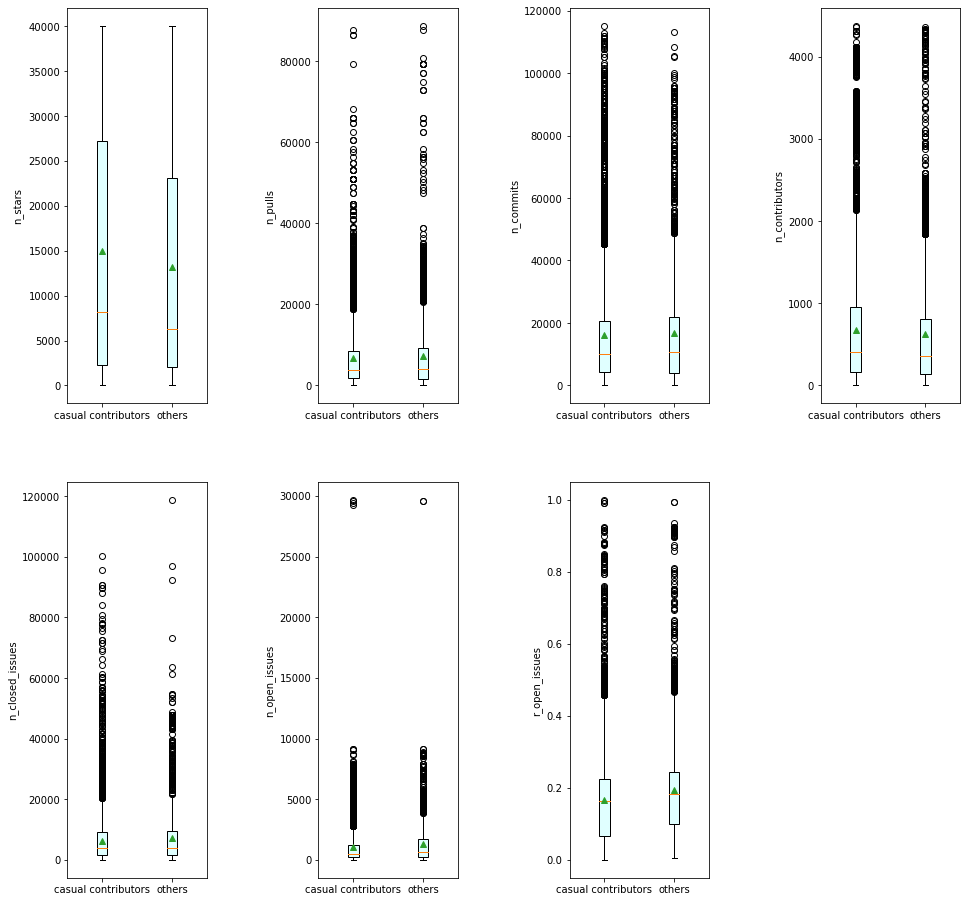

In [141]:
fig, ax_array = plt.subplots(nrows=2, ncols=4, figsize=(16, 16), sharey=False)

i = 0
labels = ['casual contributors', 'others']
for ax_lst in ax_array:
    for ax in ax_lst:
        if i >= 7:
            ax.set_visible(False)
            break
        a = ax.boxplot([otc_iss[metrics_bg[i]],notc_iss[metrics_bg[i]]],
                       patch_artist=True,
                       boxprops={'facecolor':'#e0ffff'},
                       showmeans=True,
#                        showfliers = False,
                       labels=labels)
        ax.set_ylabel(metrics_bg[i])
        i+=1

# plt.xticks(np.arange(0, len(labels)), labels)
plt.subplots_adjust(wspace=0.8)
plt.show()

In [84]:
file_type_lst = []
for index, data in otc_iss.iterrows():
    for i in data["changed_files_list"]:
        if "/" in i[0].split(".")[-1]:
            print(i[0])
            continue
        if i[0].split(".")[-1] not in file_type_lst:            
            file_type_lst.append(i[0].split(".")[-1])
print(file_type_lst)

examples/using-square-payments/LICENSE
bin/next-init
bin/next-dev
packages/next/client/portal/LICENSE
packages/create-next-app/templates/default/gitignore
tests/templates/test_all_templates
lib/plugins/create/templates/aws-java-gradle/gradlew
lib/plugins/create/templates/kubeless-nodejs/gitignore
lib/plugins/create/templates/kubeless-python/gitignore
lib/plugins/create/templates/aws-go-dep/Makefile
lib/plugins/create/templates/aws-go-dep/gitignore
lib/plugins/create/templates/aws-go/Makefile
lib/plugins/create/templates/aws-go/gitignore
tests/templates/integration-test-template
tests/templates/test_all_templates
lib/plugins/create/templates/webtasks-nodejs/gitignore
tests/templates/test_all_templates
lib/plugins/create/templates/aws-ruby/gitignore
tests/templates/test_all_templates
lib/plugins/create/templates/azure-nodejs-typescript/gitignore
tools/deployment/osqueryctl
dockerfiles/full/Dockerfile
dockerfiles/mingw-arch/Dockerfile
dockerfiles/ubuntu_amd64/Dockerfile
dockerfiles/ubuntu

In [195]:
otc_languages = dict(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(otc_iss.language).items(), key=lambda x: x[1])
))
notc_languages = dict(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(notc_iss.language).items(), key=lambda x: x[1])
))

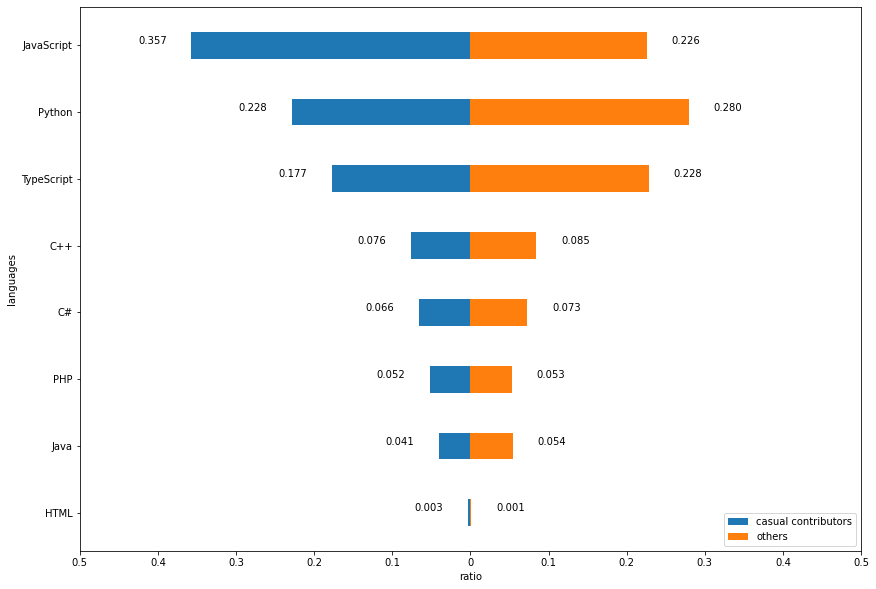

In [210]:
x_counter = np.arange(len(otc_languages.keys()))
y_counter1 = [-x for x in otc_languages.values()]
y_counter2 = [notc_languages[key] for key in otc_languages.keys()]

plt.figure(figsize=(14, 10))
plt.barh(x_counter, y_counter1, height=0.4, align='center', label='casual contributors')
plt.barh(x_counter, y_counter2, height=0.4, align='center', label='others')
for a, b in zip(y_counter1, x_counter):
    plt.text(a-0.05, b-0.01, '%.3f' % -a, ha='center', va='bottom')
for a, b in zip(y_counter2, x_counter):
    plt.text(a+0.05, b-0.01, '%.3f' % a, ha='center', va='bottom')
plt.xlabel('ratio')
plt.ylabel('languages')
plt.xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], [0.5, 0.4, 0.3, 0.2, 0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.yticks(x_counter, otc_languages.keys())
plt.legend(loc="lower right")
plt.show()

# 语言

In [23]:
def language_n(language:str)->int:
    if language == 'JavaScript':
        return 1
    if language == 'Python':
        return 2
    if language == 'TypeScript':
        return 3
#     if language == 'C++':
#         return 4
#     if language == 'C#':
#         return 5
#     if language == 'PHP':
#         return 6
#     if language == 'java':
#         return 7
#     if language == 'HTML':
#         return 8
    return 0
otc_data['language_n'] = otc_data.language.map(language_n)
notc_data['language_n'] = notc_data.language.map(language_n)
print(otc_data['language_n'].describe(),notc_data['language_n'].describe())
print(mannwhitneyu(otc_data['language_n'], notc_data['language_n']))

count    11308.000000
mean         1.345419
std          1.027386
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: language_n, dtype: float64 count    3633.000000
mean        1.470685
std         1.112248
min         0.000000
25%         0.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: language_n, dtype: float64
MannwhitneyuResult(statistic=19228176.5, pvalue=8.816715514327965e-10)


In [34]:
otc_data['reporter_commits'] = otc_data.reporter_feat.map(lambda x:x['n_commits'])
notc_data['reporter_commits'] = notc_data.reporter_feat.map(lambda x:x['n_commits'])
otc_data['reporter_issues'] = otc_data.reporter_feat.map(lambda x:x['n_issues'])
notc_data['reporter_issues'] = notc_data.reporter_feat.map(lambda x:x['n_issues'])
otc_data['reporter_pulls'] = otc_data.reporter_feat.map(lambda x:x['n_pulls'])
notc_data['reporter_pulls'] = notc_data.reporter_feat.map(lambda x:x['n_pulls'])
otc_data['reporter_repos'] = otc_data.reporter_feat.map(lambda x:x['n_repos'])
notc_data['reporter_repos'] = notc_data.reporter_feat.map(lambda x:x['n_repos'])
metrics_reporter = [
    "reporter_commits", "reporter_issues", "reporter_pulls", "reporter_repos"
]

In [35]:
otc_data[metrics_reporter].describe()

,reporter_commits,reporter_issues,reporter_pulls,reporter_repos
count,11308.000000,11308.000000,11308.000000,11308.000000
mean,249.539087,87.859392,77.437124,24.927397
std,1081.510111,266.078258,213.232866,27.326311
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,5.000000
50%,0.000000,3.000000,1.000000,15.000000
75%,5.000000,36.000000,24.000000,35.000000
max,25643.000000,9507.000000,2522.000000,199.000000


In [36]:
notc_data[metrics_reporter].describe()

,reporter_commits,reporter_issues,reporter_pulls,reporter_repos
count,3633.000000,3633.000000,3633.000000,3633.000000
mean,316.026975,90.740435,69.745114,24.725846
std,1197.073838,278.491037,184.596118,27.241784
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,5.000000
50%,1.000000,6.000000,2.000000,15.000000
75%,59.000000,52.000000,48.000000,36.000000
max,25835.000000,9507.000000,2411.000000,211.000000


In [37]:
for metric in metrics_reporter:
    print(f"{metric:30} {mannwhitneyu(otc_data[metric], notc_data[metric])}")

reporter_commits               MannwhitneyuResult(statistic=18568937.0, pvalue=3.750147059352295e-22)
reporter_issues                MannwhitneyuResult(statistic=17932262.5, pvalue=2.6906857174802545e-32)
reporter_pulls                 MannwhitneyuResult(statistic=19474456.5, pvalue=7.322597645838008e-07)
reporter_repos                 MannwhitneyuResult(statistic=20430046.0, pvalue=0.311808554090478)


In [ ]:
# 选择一部分issue进行人工查看

In [18]:
np.random.seed(0)
rand1 = np.random.randint(0, len(otc_iss), size=int(0.01*len(otc_iss)))
rand2 = np.random.randint(0, len(notc_iss), size=int(0.03*len(notc_iss)))

otc_selected = otc_iss.iloc[rand1].copy()
notc_selected = notc_iss.iloc[rand2].copy()

otc_selected['url'] = "https://github.com/" + otc_selected['owner'] + "/" + otc_selected['name'] + "/issues/" + otc_selected['number'].astype(str)
notc_selected['url'] = "https://github.com/" + notc_selected['owner'] + "/" + notc_selected['name'] + "/issues/" + notc_selected['number'].astype(str)

In [21]:
otc_selected = otc_selected[['owner','name','number','resolver','url']]
notc_selected = notc_selected[['owner','name','number','resolver','url']]

In [22]:
# otc_selected.to_csv('../data/otc_selected.csv', index=False, header=True)
with pd.ExcelWriter('../data/selected_iss.xls') as writer:
    otc_selected.to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_selected.to_excel(writer, sheet_name='notc', index=False, header=True)

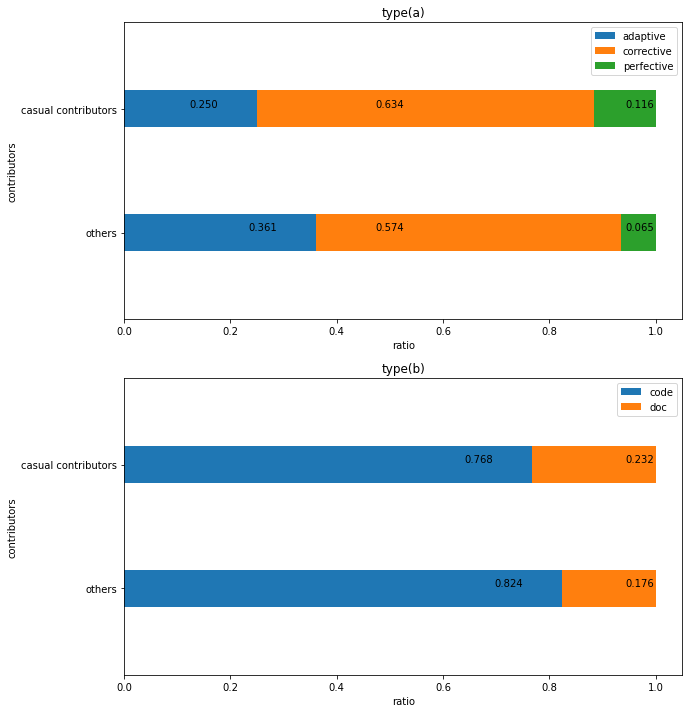

In [53]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharey=False)
# x轴
x_counter = [1,2]
x_label = ['others', 'casual contributors']

# y轴
y_counter1 = np.array([39,28])
y_counter2 = np.array([62,71])
y_counter3 = np.array([7,13])
sumy = y_counter1 + y_counter2 + y_counter3
for a, b in zip(y_counter1/sumy, x_counter):
    ax1.text(a-0.1, b, '%.3f' % a, ha='center', va='bottom')
for a, b in zip(y_counter2/sumy, x_counter):
    ax1.text(0.5, b, '%.3f' % a, ha='center', va='bottom')
for a, b in zip(y_counter3/sumy, x_counter):
    ax1.text(0.97, b, '%.3f' % a, ha='center', va='bottom')    
ax1.barh(x_counter, y_counter1/sumy, height=0.3, align='center', label='adaptive')
ax1.barh(x_counter, y_counter2/sumy, height=0.3, left=y_counter1/sumy, align='center', label='corrective')
ax1.barh(x_counter, y_counter3/sumy, height=0.3, left=(y_counter1+y_counter2)/sumy, align='center', label='perfective')
ax1.legend(loc="upper right")
ax1.set_xlabel('ratio')
ax1.set_ylabel('contributors')
ax1.set_yticks(x_counter)
ax1.set_yticklabels(x_label)
ax1.set_ylim(0.3,2.7)
ax1.set_title('type(a)')
# axs[1].set_xticklabels(name, rotation=90)


# y轴
y_counter1 = np.array([89,86]) # code
y_counter2 = np.array([19,26]) 
sumy = y_counter1 + y_counter2
for a, b in zip(y_counter1/sumy, x_counter):
    ax2.text(a-0.1, b, '%.3f' % a, ha='center', va='bottom')
for a, b in zip(y_counter2/sumy, x_counter):
    ax2.text(0.97, b, '%.3f' % a, ha='center', va='bottom')    
ax2.barh(x_counter, y_counter1/sumy, height=0.3, align='center', label='code')
ax2.barh(x_counter, y_counter2/sumy, height=0.3, left=y_counter1/sumy, align='center', label='doc')
ax2.legend(loc="upper right")
ax2.set_xlabel('ratio')
ax2.set_ylabel('contributors')
ax2.set_yticks(x_counter)
ax2.set_yticklabels(x_label)
ax2.set_ylim(0.3,2.7)
ax2.set_title('type(b)')

plt.legend()  # 让图例生效

In [ ]:
# 选notc issue多的项目

In [9]:
print(len(notc_iss))
dict(map(
lambda x: (x[0], x[1]), 
sorted(Counter(notc_iss.owner+"/"+notc_iss.name).items(), key=lambda x: -x[1])[0:10]
))

3633


{'pandas-dev/pandas': 375,
 'freeCodeCamp/freeCodeCamp': 248,
 'CleverRaven/Cataclysm-DDA': 179,
 'mui/material-ui': 164,
 'aws/aws-cdk': 137,
 'microsoft/vscode': 116,
 'scikit-learn/scikit-learn': 115,
 'sympy/sympy': 110,
 'Yoast/wordpress-seo': 101,
 'eslint/eslint': 97}

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(s):
    s = s.lower()
    wordcloud = WordCloud(background_color="white",\
                      width = 400,\
                      height = 400,\
                      max_font_size = 80,\
                      contour_width = 3,\
                      contour_color = 'steelblue'
                      ).generate(s)
#                       ).generate_from_frequencies(dic1)
    return wordcloud
    
def clean_iss_body(s:str) -> str:  
    s = re.sub(r'```.*\n([\s\S]*?)```', '', s)# 去除代码块   
    s = re.sub(r'!\[.*\]\(.*\)', '', s)# 去除图片    
    s = re.sub(r'\[.*\]\(.*\)', '', s)# 去除链接   
    s = re.sub(r'#+ .*', '', s) # 去除标题
    s = re.sub('[\n\r\s]+', ' ', s) # 去除多余的空格和换行符
    # 去除其他Markdown标记
    s = re.sub(r'[*_~`|]', '', s) 
    s = re.sub(r'<[^>]+>','',s)
    s = re.sub(r'\/\w+', '', s)
    s = re.sub(r'\\\w+', '', s)
    # 去除停止词
    return s

In [214]:
# pandas数据集
otc_pandas = otc_iss[(otc_iss['owner'] == 'pandas-dev')&(otc_iss['name'] == 'pandas')].copy()
notc_pandas = notc_iss[(notc_iss['owner'] == 'pandas-dev')&(notc_iss['name'] == 'pandas')].copy()

otc_pandas['url'] = "https://github.com/pandas-dev/pandas/issues/" + otc_pandas['number'].astype(str)
notc_pandas['url'] = "https://github.com/pandas-dev/pandas/issues/" + notc_pandas['number'].astype(str)

with pd.ExcelWriter('../data/pandas_iss.xls') as writer:
    otc_pandas[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_pandas[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='notc', index=False, header=True)

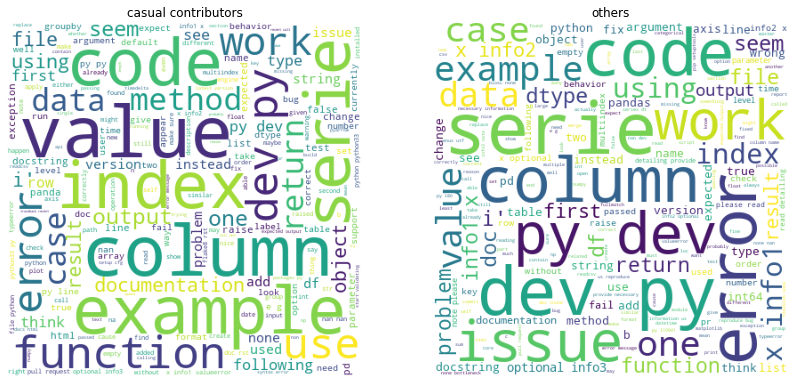

In [9]:
def plot_pandas_iss_body(iss, owner:str, name:str):
    tmp_df = iss[(iss.owner == owner) & (iss.name == name)]
    s_lst = list(tmp_df.body)
    s_lst = [s.split('<details>',1)[0] for s in s_lst]
    s_lst.append('containDetails')
    s = ''.join(s_lst)
#     print(s_lst)
#     return
    s = re.sub(r'I have checked that this issue has not already been reported.','info1',s)
    s = re.sub(r'I have confirmed this bug exists on the latest version of pandas.','info2',s)
    s = re.sub(r'I have confirmed this bug exists on the master branch of pandas.','info3',s)
    s = re.sub(r'I have confirmed this bug exists on the main branch of pandas.','info3',s)
    s = re.sub(r'dataframe','',s)
    s = re.sub(r'DataFrame','',s)
#     s = re.sub(r'error','',s)
    s = re.sub(r'pandas','',s)
    s = clean_iss_body(s)
    s = re.sub(r"\b(i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\b", '', s)
    return plot_word_cloud(s)

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 10), sharey=False)
ax1.imshow(plot_pandas_iss_body(otc_iss, 'pandas-dev', 'pandas'))
ax1.axis("off")
ax1.set_title('casual contributors')
ax2.imshow(plot_pandas_iss_body(notc_iss, 'pandas-dev', 'pandas'))
ax2.axis("off")
ax2.set_title('others')
plt.show()

In [92]:
tmp_df = notc_iss[(notc_iss.owner == "pandas-dev") & (notc_iss.name == "pandas")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "pandas-dev") & (otc_iss.name == "pandas")]
print("otc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("otc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))

notc code snips: 621 1.656
notc urls and imgs: 327 0.872
otc code snips: 1419 1.5714285714285714
otc urls and imgs: 826 0.9147286821705426


In [93]:
# freeCodeCamp数据集
otc_freeCodeCamp = otc_iss[(otc_iss['owner'] == 'freeCodeCamp')&(otc_iss['name'] == 'freeCodeCamp')].copy()
notc_freeCodeCamp = notc_iss[(notc_iss['owner'] == 'freeCodeCamp')&(notc_iss['name'] == 'freeCodeCamp')].copy()

otc_freeCodeCamp['url'] = "https://github.com/freeCodeCamp/freeCodeCamp/issues/" + otc_freeCodeCamp['number'].astype(str)
notc_freeCodeCamp['url'] = "https://github.com/freeCodeCamp/freeCodeCamp/issues/" + notc_freeCodeCamp['number'].astype(str)

with pd.ExcelWriter('../data/freeCodeCamp_iss.xls') as writer:
    otc_freeCodeCamp[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_freeCodeCamp[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='notc', index=False, header=True)

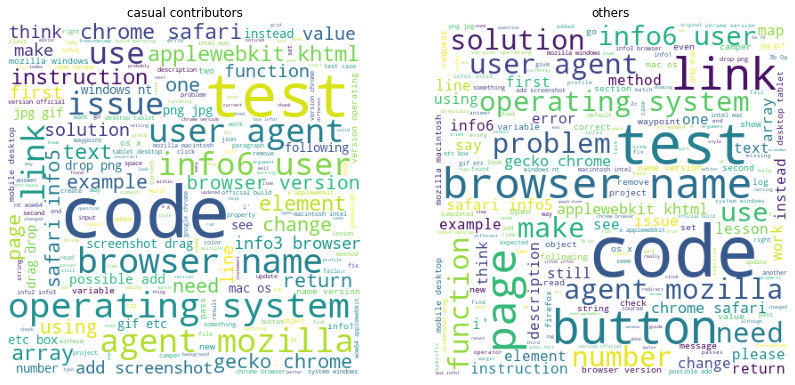

In [195]:
def plot_freeCodeCamp_iss_body(iss, owner:str, name:str):
    tmp_df = iss[(iss.owner == owner) & (iss.name == name)]
    s = tmp_df.body.sum()
#     print(s_lst)
#     return
    s = re.sub(r'Describe your problem and how to reproduce it:','info1',s)
    s = re.sub(r'Add a Link to the page with the problem:','info2',s)
    s = re.sub(r'Tell us about your browser and operating system:','info3',s)
    s = re.sub(r'If possible, add a screenshot here (you can drag and drop, png, jpg, gif, etc. in this box):','info4',s)    
    s = re.sub(r'Please describe how to reproduce it, and include links to screenshots if possible.','info5',s)
    s = re.sub(r'Please describe how to reproduce this issue, and include links to screenshots if possible.','info5',s)    
    s = clean_iss_body(s)        
    s = re.sub(r'Challenge has an issue','info6',s)
    s = re.sub(r"\-\w+", "", s)
    s = re.sub(r"Challenge  has an issue", 'info6', s)
    s = re.sub(r'Your code Copy and paste the code from the editor that you used in between the back below','info7',s)
    s = re.sub(r"Challenge", '', s)
    s = re.sub(r"challenge", '', s)
    s = re.sub(r"\b(i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\b", '', s)
    
#     s = re.sub(r"code", '', s)
#     s = re.sub(r"test", '', s)
    return plot_word_cloud(s)

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 10), sharey=False)
ax1.imshow(plot_freeCodeCamp_iss_body(otc_iss, 'freeCodeCamp', 'freeCodeCamp'))
ax1.axis("off")
ax1.set_title('casual contributors')
ax2.imshow(plot_freeCodeCamp_iss_body(notc_iss, 'freeCodeCamp', 'freeCodeCamp'))
ax2.axis("off")
ax2.set_title('others')
plt.show()

In [115]:
tmp_df = notc_iss[(notc_iss.owner == "freeCodeCamp") & (notc_iss.name == "freeCodeCamp")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "freeCodeCamp") & (otc_iss.name == "freeCodeCamp")]
print("otc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("otc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))

notc code snips: 87 0.35080645161290325
notc urls and imgs: 384 1.5483870967741935
otc code snips: 323 0.4261213720316623
otc urls and imgs: 1462 1.928759894459103


In [117]:
# CataclysmDDA数据集
otc_Cataclysm = otc_iss[(otc_iss['owner'] == 'CleverRaven')&(otc_iss['name'] == 'Cataclysm-DDA')].copy()
notc_Cataclysm = notc_iss[(notc_iss['owner'] == 'CleverRaven')&(notc_iss['name'] == 'Cataclysm-DDA')].copy()

otc_Cataclysm['url'] = "https://github.com/CleverRaven/Cataclysm-DDA/issues/" + otc_Cataclysm['number'].astype(str)
notc_Cataclysm['url'] = "https://github.com/CleverRaven/Cataclysm-DDA/issues/" + notc_Cataclysm['number'].astype(str)

with pd.ExcelWriter('../data/Cataclysm_iss.xls') as writer:
    otc_Cataclysm[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_Cataclysm[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='notc', index=False, header=True)

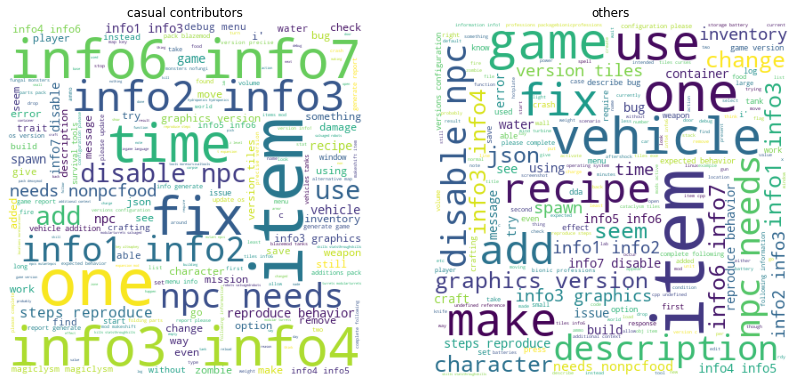

In [14]:
def plot_Cataclysm_iss_body(iss, owner:str, name:str):
    tmp_df = iss[(iss.owner == owner) & (iss.name == name)]
    s = tmp_df.body.sum()
    s = re.sub(r'OS:.*?\n','info1',s)    
    s = re.sub(r'OS Version:.*?\n','info2',s)
    s = re.sub(r'Game Version:.*?\n','info3',s)
    s = re.sub(r'Graphics Version:.*?\n','info4',s)    
    s = re.sub(r'Game Language:.*?\n','info5',s)
    s = re.sub(r'Mods loaded.*?\n','info6',s)
    s = re.sub(r'Dark Days Ahead.*?\n','info7',s)
    s = clean_iss_body(s)        
#     print(s)
    s = re.sub(r"\b(i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\b", '', s)
    
    return plot_word_cloud(s)

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 10), sharey=False)
ax1.imshow(plot_Cataclysm_iss_body(otc_iss,'CleverRaven', 'Cataclysm-DDA'))
ax1.axis("off")
ax1.set_title('casual contributors')
ax2.imshow(plot_Cataclysm_iss_body(notc_iss, 'CleverRaven', 'Cataclysm-DDA'))
ax2.axis("off")
ax2.set_title('others')
plt.show()

In [168]:
tmp_df = notc_iss[(notc_iss.owner == "CleverRaven") & (notc_iss.name == "Cataclysm-DDA")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "CleverRaven") & (otc_iss.name == "Cataclysm-DDA")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))

notc code snips: 25 0.13966480446927373
notc urls and imgs: 171 0.9553072625698324
notc code snips: 39 0.0745697896749522
notc urls and imgs: 395 0.7552581261950286


In [169]:
# mui数据集
otc_mui = otc_iss[(otc_iss['owner'] == 'mui')&(otc_iss['name'] == 'material-ui')].copy()
notc_mui = notc_iss[(notc_iss['owner'] == 'mui')&(notc_iss['name'] == 'material-ui')].copy()

otc_mui['url'] = "https://github.com/mui/material-ui/issues/" + otc_mui['number'].astype(str)
notc_mui['url'] = "https://github.com/mui/material-ui/issues/" + notc_mui['number'].astype(str)

with pd.ExcelWriter('../data/mui_iss.xls') as writer:
    otc_mui[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_mui[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='notc', index=False, header=True)

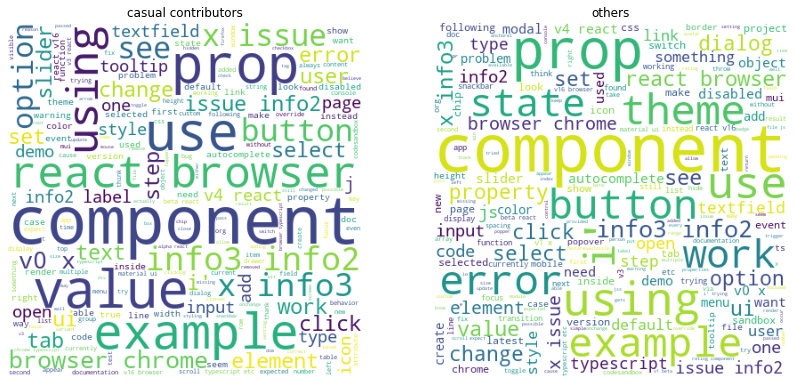

In [205]:
def plot_mui_iss_body(iss, owner:str, name:str):
    tmp_df = iss[(iss.owner == owner) & (iss.name == name)]
    s = tmp_df.body.sum()      
    s = re.sub(r'Tech  Version','version',s)
    s = re.sub(r"material-ui", "", s)
    s = re.sub(r"Material-UI", "", s)
    s = re.sub(r'I have searched the','info1',s)
    s = re.sub(r"of this repository and believe that this is not a duplicate.", 'info2', s)
    s = re.sub(r'The issue is present in the latest release.','info3',s)
    s = clean_iss_body(s)
    s = re.sub(r"Tech  Version", "", s)
    s = re.sub(r"\b(i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\b", '', s)
#     print(s)
    
    return plot_word_cloud(s)

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 10), sharey=False)
ax1.imshow(plot_mui_iss_body(otc_iss,'mui', 'material-ui'))
ax1.axis("off")
ax1.set_title('casual contributors')
ax2.imshow(plot_mui_iss_body(notc_iss,'mui', 'material-ui'))
ax2.axis("off")
ax2.set_title('others')
plt.show()

In [206]:
tmp_df = notc_iss[(notc_iss.owner == "mui") & (notc_iss.name == "material-ui")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "mui") & (otc_iss.name == "material-ui")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))

notc code snips: 90 0.5487804878048781
notc urls and imgs: 431 2.6280487804878048
notc code snips: 385 0.511968085106383
notc urls and imgs: 1892 2.515957446808511


In [209]:
# cdk数据集
otc_cdk = otc_iss[(otc_iss['owner'] == 'aws')&(otc_iss['name'] == 'aws-cdk')].copy()
notc_cdk = notc_iss[(notc_iss['owner'] == 'aws')&(notc_iss['name'] == 'aws-cdk')].copy()

otc_cdk['url'] = "https://github.com/aws/aws-cdk/issues/" + otc_cdk['number'].astype(str)
notc_cdk['url'] = "https://github.com/aws/aws-cdk/issues/" + notc_cdk['number'].astype(str)

with pd.ExcelWriter('../data/cdk_iss.xls') as writer:
    otc_cdk[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_cdk[['owner','name','number','resolver','url']].to_excel(writer, sheet_name='notc', index=False, header=True)

OS: Arch Linux ( I ' think ' specific  ) Looks like ' running npm install  putting  bin folder   'tcdk.ts'.We   template  typescript,   need one  javascript  wellI     challenges   new ASG (  0.8.3?). 1. I   simple pattern using cfn-signal   basic rolling update. The issue  I need  logical ID   ASG   command. If I use CDK ASG construct (  CloudFormation one). I   means  get  LogicalId   ASG. There might   tricks   rename functions,  I' pretty sure  want  elegant solution . I added  method   ASG  get logical ID    work. I think I would prefer  model  cfn- functions actually   OperatingSystem implementations, similar  createUserData(..). 1. The security group pattern via Connections   lot  great features,  I think I might still need access  either assign additional security groups  export  default one assigned. The primary use case   bastion pattern. We  exported  bastion node security group   instances use cross stack references  allow inbound port 22   security group   bastion node. We

There   bug  CloudFormation  cases Updates   AWS::CloudWatch::Dashboard  fail  DashboardName   supplied. We    CDK-local workaround   generate  name   user ' supply one. Once  upstream bug  fixed,   remove  workaround.When I saw  another issue  tag propagation  added,  first instinct   try  set tags   software.amazon.awscdk.App ( possible,   implement ITaggable,  least  java),   tried  set tags   software.amazon.awscdk.Stack ( problem). My use case   (1) add tags   App level  propagation,  (2)   set    AWS::CloudFormation::Stack resources created  cdk deploy,   turn (3)   set    resources created within said stacks. I tried implementing ITaggable   App subclass   Stack subclass. The tags get passed  set   way   resources  right,  ' (1)  (3) covered. But   (2)? If I understand  design correctly, ' completely reliant  changesets,   tags   Stacks cannot  passed   stack template. They would    passed   api call  createChangeSet: Makes sense? In CloudFormation, allows  specify  optional [we

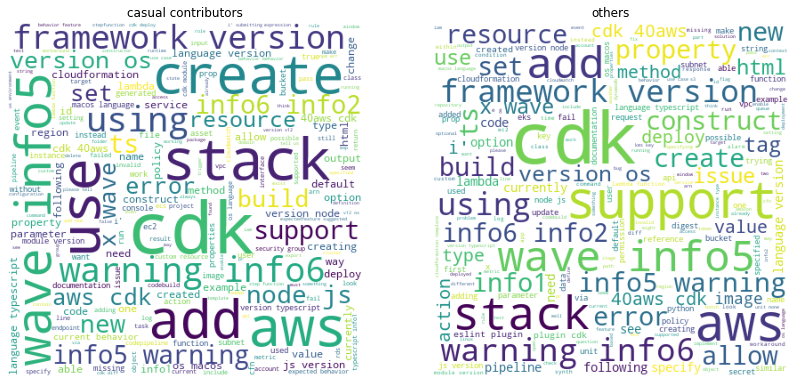

In [223]:
def plot_cdk_iss_body(iss, owner:str, name:str):
    tmp_df = iss[(iss.owner == owner) & (iss.name == name)]
    s = tmp_df.body.sum()      
#     s = re.sub(r'Tech  Version','version',s)
#     s = re.sub(r"material-ui", "", s)
    s = re.sub(r"CLI Version", "", s) 
    s = re.sub(r"This is :bug: Bug Report", 'info1', s)
    s = re.sub(r'This is a :rocket: Feature Request','info2',s)
    s = re.sub(r':rocket: feature request','featureRequest',s)
    s = re.sub(r':beetle: bug report','bugReport',s)  
    s = re.sub(r'I may be able to implement this feature request','info5',s)  
    s = re.sub(r'This feature might incur a breaking change','info6',s)  
    
    s = clean_iss_body(s)
    
    s = re.sub(r"\b(i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\b", '', s)
    print(s)
    
    return plot_word_cloud(s)

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 10), sharey=False)
ax1.imshow(plot_cdk_iss_body(otc_iss,'aws', 'aws-cdk'))
ax1.axis("off")
ax1.set_title('casual contributors')
ax2.imshow(plot_cdk_iss_body(notc_iss,'aws', 'aws-cdk'))
ax2.axis("off")
ax2.set_title('others')
plt.show()

In [224]:
tmp_df = notc_iss[(notc_iss.owner == "aws") & (notc_iss.name == "aws-cdk")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "aws") & (otc_iss.name == "aws-cdk")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls and imgs:", sum(tmp_df.n_urls)+sum(tmp_df.n_imgs), (sum(tmp_df.n_urls)+sum(tmp_df.n_imgs))/len(tmp_df))

notc code snips: 137 1.0
notc urls and imgs: 180 1.313868613138686
notc code snips: 230 1.0176991150442478
notc urls and imgs: 299 1.323008849557522
